### Importing modules

In [1]:
# Import necessary libraries
import glob
from helpers import process_inputs, check_user_FITS_file
from preset_source_models import ModelSourceMaker
from simulate_ALMA_observations import run_simalma, extract_MS_data

### Loading user inputs from file

In [2]:
# Load inputs from the YAML file
inputs = process_inputs("inputs")

### Generating/loading source model

In [3]:
# Run if the user has requested to use a specified preset source model
if inputs.modules.generate_preset_source_model:
    print("Generating a source model from a preset.\n")
    print("User specified parameters:")
    for key, value in vars(inputs.preset_model).items():
        print(f"{key}: {value}")
    print("\n")

    # Generate a source model from a preset and save it to a FITS file
    ###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###
    # Initialise the preset model factory
    factory = ModelSourceMaker(
        fov_arcsec=inputs.preset_model.fov_arcsec,
        npix=inputs.preset_model.npix,
        freq_Hz=float(inputs.preset_model.freq_Hz),
        chan_width_Hz=float(inputs.preset_model.chan_width_Hz),
        ra_dec_center=inputs.preset_model.ra_dec_center)

    # Get the preset function name and parameters from the inputs
    func_name = inputs.preset_model.preset_function_name

    # Get the method from the factory
    model_func = getattr(factory, func_name)

    # Get the model name from inputs
    model_name = inputs.preset_model.model_name

    # Filter out keys that are not arguments to the model function
    params = {k: v for k, v in vars(inputs.preset_model).items()
            if k not in ["fov_arcsec", "npix", "freq_Hz", "chan_width_Hz", "ra_dec_center", "preset_function_name", "model_name"]}

    # Generate and save the source model image to a FITS file
    fits_file = factory.generate_and_save(model_name, model_func(**params))
    ###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###

elif (inputs.modules.generate_preset_source_model==False) and (inputs.modules.use_user_defined_FITS_source_model==True):
    print(f"Using a user-defined FITS source model: {inputs.user_model.user_source_model_file}.")
    fits_file = inputs.user_model.user_source_model_file

Generating a source model from a preset.

User specified parameters:
fov_arcsec: 0.1
npix: 128
ra_dec_center: 23h59m59.96s -34d59m59.50s
freq_Hz: 33.0e9
chan_width_Hz: 5.0e7
preset_function_name: flat_disk
model_name: flat_disk
radius_arcsec: 0.03
intensity: 2.5


Source model FITS file saved to: source_model/flat_disk.fits
Image of source model saved as PDF to: source_model/flat_disk.pdf


### Checking FITS file format for simalma

In [4]:
# Check if the input/generated Fits file has the correct header and data structure
check_user_FITS_file(fits_file=fits_file)

True

### Running simalma

Running simalma with the following parameters:
project: flat_disk
skymodel: source_model/flat_disk.fits
inbright: 0.004
indirection: J2000 23h59m59.96s -34d59m59.50s
incell: 0.1arcsec
incenter: 330.076GHz
inwidth: 50MHz
mapsize:  
antennalist: ['alma.cycle5.3.cfg']
totaltime: 1800s
tptime: 0s
pwv: 0.6
overwrite: True




2025-05-31 02:21:15	WARN	simalma::::casa	saveinputs not available in casatasks, skipping saving simalma inputs
2025-05-31 02:21:15	WARN	simalma::simalma::casa	------------------------------------------------------------
2025-05-31 02:21:15	WARN	simalma::simalma::casa	Step 1: simulating 12m ALMA array
2025-05-31 02:21:15	WARN	simalma::simalma::casa	------------------------------------------------------------
2025-05-31 02:21:26	WARN	noise::CTPatchedInterp::interpolate	In caltable flat_disk.alma.cycle5.3.noisy.T.cal_sim_temp (Tf Jones):
2025-05-31 02:21:26	WARN	noise::CTPatchedInterp::interpolate+	 Insufficient solution channel sampling (nchan=1) for frequency-dependent LINEAR interpolation 
2025-05-31 02:21:26	WARN	noise::CTPatchedInterp::interpolate+	 of calibration for MS spw=0; using NEAREST instead.


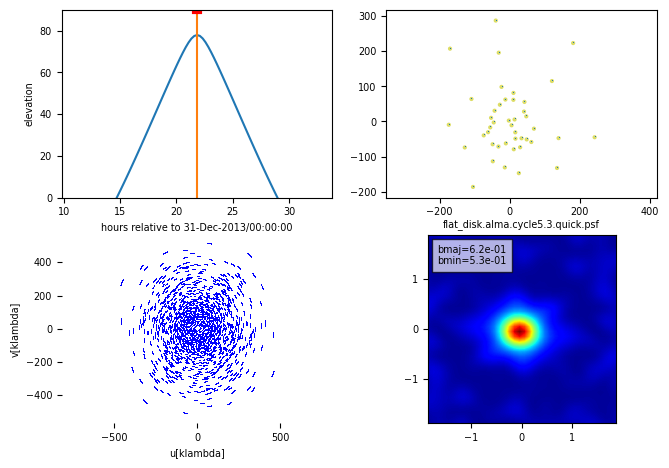

In [5]:
if inputs.modules.run_simalma_simulation:
    # Simualte the ALMA observations of the specified source model using simalma with the provided input parameters
    run_simalma(project = inputs.simalma.project_name,
                overwrite = inputs.simalma.overwrite,
                skymodel = inputs.user_model.user_source_model_file if inputs.modules.use_user_defined_FITS_source_model else inputs.simalma.skymodel,
                indirection = inputs.simalma.indirection,
                incell = inputs.simalma.incell,
                inbright = inputs.simalma.inbright,
                incenter = inputs.simalma.incenter,
                inwidth = inputs.simalma.inwidth,
                antennalist = inputs.simalma.antennalist,
                totaltime = inputs.simalma.totaltime,
                mapsize = inputs.simalma.mapsize,
                tpnant = inputs.simalma.tpnant,
                tptime = inputs.simalma.tptime,
                pwv = inputs.simalma.pwv,
                dryrun = inputs.simalma.dryrun,
                image = inputs.simalma.image
                )

### Extracting visibility data into a .npz file for RML imaging

In [6]:
if inputs.modules.extract_data_from_MS:
    # Extract the visibility data from the generated measurement set (MS) file and save it to a .npz file
    ms_path_trace = f"{inputs.simalma.project_name}/{inputs.simalma.project_name}.*.noisy.ms"
    ms_path = glob.glob(ms_path_trace)[0]

    _ = extract_MS_data(ms_path=ms_path, rml_data_path=inputs.extract_MS_data.rml_data_path, npz_file_name=inputs.extract_MS_data.npz_file_name, make_visibility_plots=True)

Number of SPWs in MS: 1
Channels per SPW: [1]
Corrs./Pols. per SPW: [2] 

Extracting data from flat_disk/flat_disk.alma.cycle5.3.noisy.ms...
(162540,) visibilities extracted from the MS
Plotting visibility data...
uv-coverage plot saved to data_for_rml/uv_coverage.pdf
Visibility plots saved to data_for_rml/visibility_plots.pdf

Visibility data saved to data_for_rml/flat_disk.npz



# TO DO / INCOMPLETE

### Loading data to MPol and making dirty image

In [7]:
if inputs.modules.set_up_data_for_RML:
    print('Loading the data for RML imaging.')

    print('Making the dirty image and the PSF.')

Loading the data for RML imaging.
Making the dirty image and the PSF.


### RML Imaging with MPol

In [8]:
if inputs.modules.run_RML_imaging:
    print('Running RML imaging on the simulated ALMA data.')